# Dataset analysis 

This notebook does straightforward analysis on the dataset and plots some simple visualisations describing it. 

In [1]:
from os.path import join, exists

import numpy as np 
import pandas as pd 

from torchvision import datasets

from tabulate import tabulate

import matplotlib.pyplot as pl 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from umap import UMAP

from evaluate import load_data
from utils import figure_loader

sns.set_style("darkgrid")

%matplotlib inline

## Some simple analysis on image properties

Load relevant data

In [2]:
labels = [
    'sandwich', 
    'sushi',
]

feat_names = [
    "alexnet", 
    "vgg11", 
    "inception", 
    "mobilenet", 
    "ensemble",
]

model_names = [
    "sgd", 
    "pcasgd",
    "gmm",
]

dataset_folder = datasets.DatasetFolder(
    'sushi_or_sandwich',
    loader=figure_loader,
    extensions=(".jpg",),
)

imgs = [ # Need to call copy on the Image-s in order to avoid an OS error 
    (figure_loader(path).copy(), label, labels[label]) for path, label in dataset_folder.samples
]

sizes = pd.DataFrame([img.size + (label,) for img, class_, label in imgs])
sizes.columns = ("height", "width", "label")
sizes.loc[:, 'aspect'] = sizes.width / sizes.height

## Plot the distribution over aspect ratio

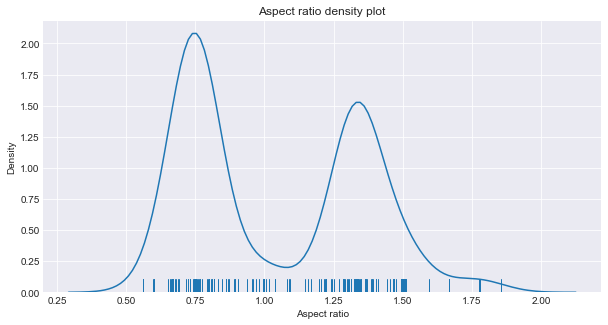

In [3]:
fig, ax = pl.subplots(1, 1, figsize=(10, 5))
sns.distplot(sizes.aspect, hist=False, rug=True, ax=ax)
pl.xlabel("Aspect ratio")
pl.ylabel("Density")
pl.title("Aspect ratio density plot")
pl.savefig(join("figures", "aspect-dist.pdf"))

## Plot a KDE plot over image width/length

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'c'
  s)


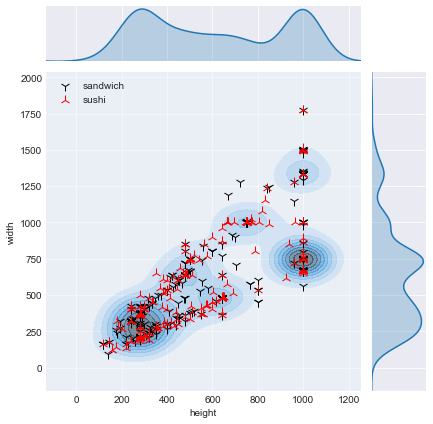

In [4]:
kde = sns.jointplot(x="height", y="width", data=sizes, c="m", kind="kde", alpha=0.5)
ax = pl.gcf().axes[0]
pl.sca(ax)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
for label, group in sizes.groupby('label'): 
    marker = dict(sandwich='1', sushi='2')[label]
    colour = dict(sandwich='k', sushi='r')[label]
    pl.scatter(group.height, group.width, lw=1, s=100, c=colour, marker=marker, label=label)
pl.legend(loc=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
pl.savefig(join("figures", "width-height-dist.pdf"))

## Feature embeddings

Here we visualise the feature embeddings of the data using the [UMAP](https://github.com/lmcinnes/umap). 

We can notice that all figures embed to one manifold with little suggesting that the classes should be easily separated. The ensemble visualisation seems to depict three (approximately distinct) clusters of sushi most clearly.

2019-09-30 12:39:03,375 - utils - INFO - Verifying alexnet in {'mobilenet', 'ensemble', 'inception', 'alexnet', 'vgg11'}
2019-09-30 12:39:18,292 - utils - INFO - Verifying vgg11 in {'mobilenet', 'ensemble', 'inception', 'alexnet', 'vgg11'}
2019-09-30 12:39:29,736 - utils - INFO - Verifying inception in {'mobilenet', 'ensemble', 'inception', 'alexnet', 'vgg11'}
2019-09-30 12:39:42,430 - utils - INFO - Verifying mobilenet in {'mobilenet', 'ensemble', 'inception', 'alexnet', 'vgg11'}
2019-09-30 12:39:54,306 - utils - INFO - Verifying ensemble in {'mobilenet', 'ensemble', 'inception', 'alexnet', 'vgg11'}


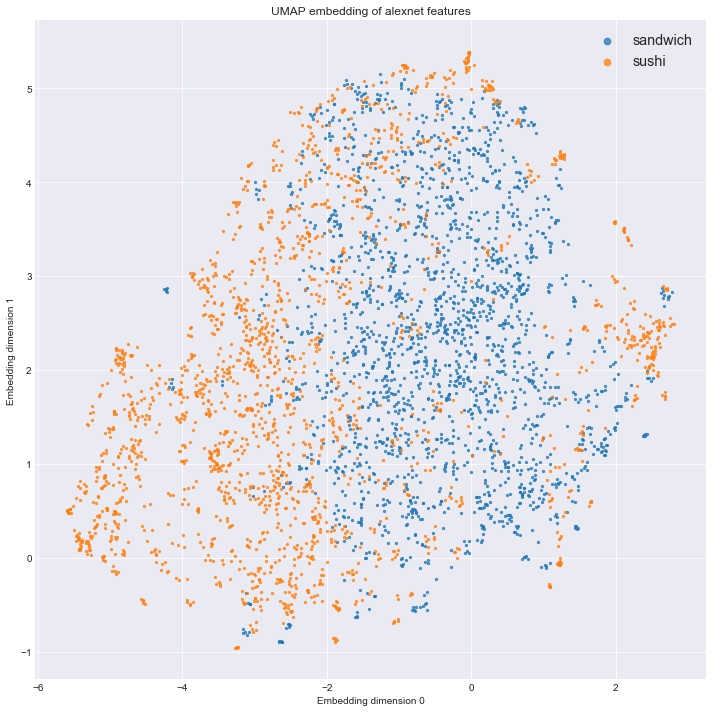

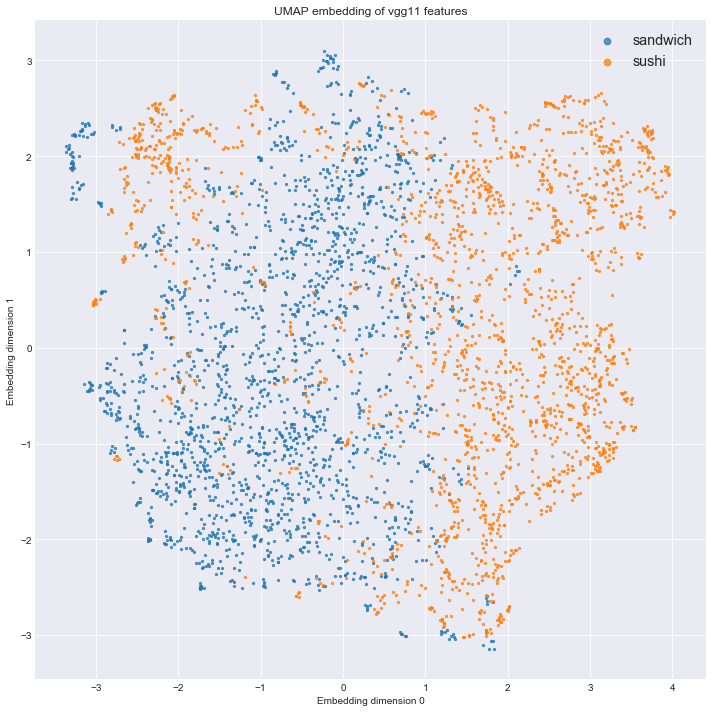

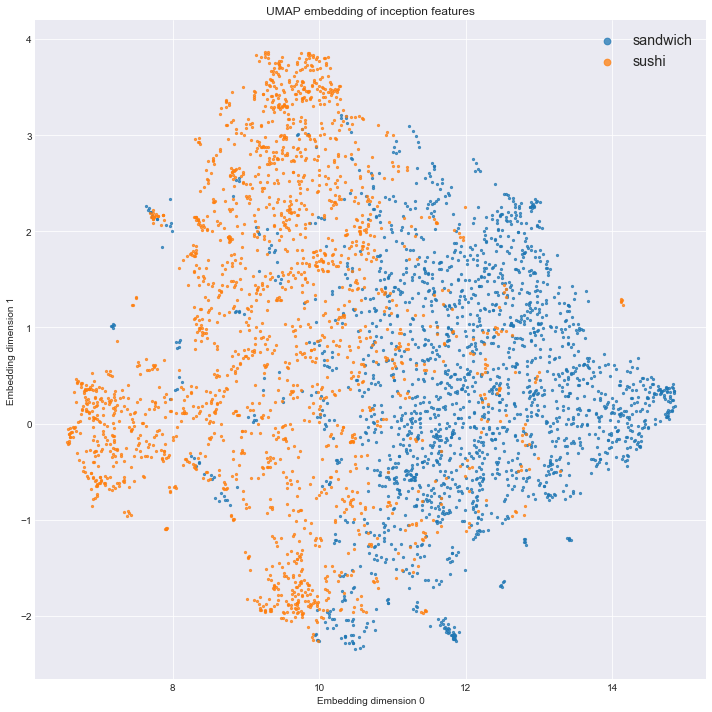

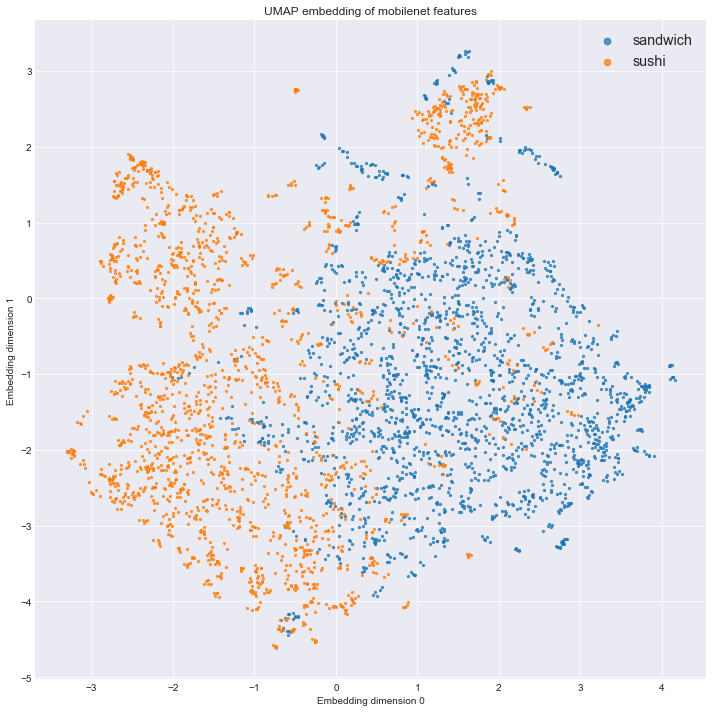

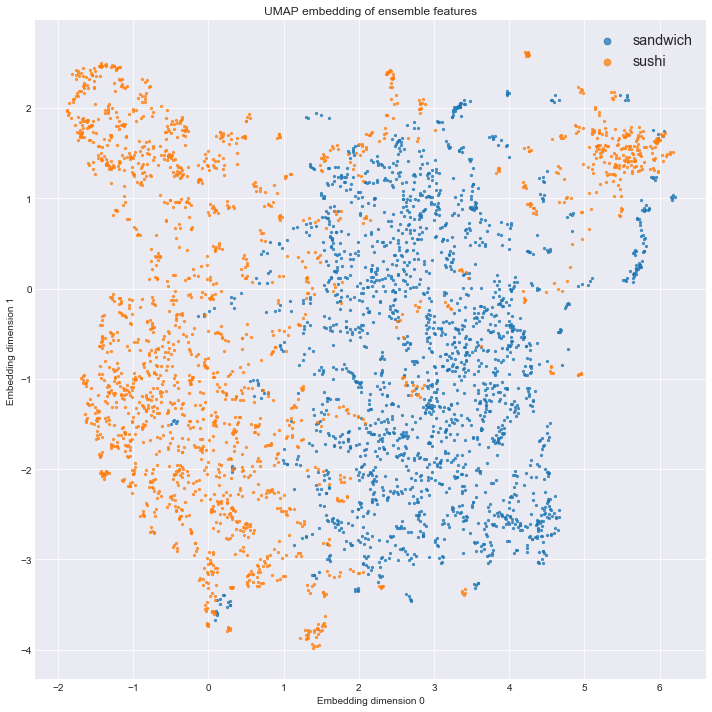

In [5]:
for feat_name in feat_names: 
    # Load the features from fold (acorss all folds)
    xx, _, yy, _ = load_data("build", feat_name, None, 5)[0]
    xx, yy = np.asarray(xx), np.asarray(yy)
    
    # Define the model and calculate the embedding
    model = Pipeline((
        ('stand', StandardScaler()), 
        ('umap', UMAP(50)),
    )).fit(xx)
    embedding = model.transform(xx)
    del xx
    
    # Plot the embeddings, stratifying by class label
    fig, ax = pl.subplots(1, 1, figsize=(10, 10))
    labels = np.unique(yy)
    colours = sns.color_palette(n_colors=labels.shape[0])
    for ll, cc in zip(labels, colours):
        inds = yy == ll
        ax.scatter(
            embedding[inds, 0],
            embedding[inds, 1],
            c=cc, label=ll, s=5,
            alpha=0.75
        )
        
    # Set labels, title and save figure
    pl.legend(fontsize='x-large', markerscale=3)
    pl.title(f"UMAP embedding of {feat_name} features")
    pl.xlabel("Embedding dimension 0")
    pl.ylabel("Embedding dimension 1")
    
    pl.tight_layout()
    pl.savefig(join("figures", f"umap-{feat_name}.pdf"))